In [75]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random
from scipy.stats import norm

In [93]:
np.random.seed(1234)

sequence_length = 100
epochs = 15
batch_size = 100

In [94]:
def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise return: the final wave
    """
    t = np.arange(0.0, 20.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.2, len(t))
    wave1 = wave1 + noise
    wave2 = sin(2 * pi * t)
     
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = 0.5*sin(10 * pi * t_rider)
     
    insert = round(0.9 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    wave1[1700] = wave1[1700] + 0.65
    return wave1 + wave2

In [95]:
def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [96]:
def get_split_prep_data(train_start, train_end, test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)
 
    X_train = result[:, :-1]
    y_train = result[:, -1]
    
    # test data
    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  #
    result, result_mean = z_norm(result)
    X_test = result[:, :-1]
    y_test = result[:, -1]
      
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))
    
    return X_train, y_train, X_test, y_test

In [97]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 32, 'hidden2': 64, 'hidden3': 64, 'output': 1}

    model.add(LSTM(return_sequences=True, units=layers['hidden1'], input_shape=(sequence_length - 1, layers['input'])))
    model.add(Dropout(0.2))

    model.add(LSTM(layers['hidden2'], return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers['hidden3'], return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    model.add(Activation("selu"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam")
    print ("Compilation Time : ", time.time() - start)
    return model

In [98]:
def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print ('Loading data... ')
        X_train, y_train, X_test, y_test = get_split_prep_data(0, 1400, 1500, 2000)
    else:
        X_train, y_train, X_test, y_test = data

    print ('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    try:
        plt.figure(figsize=(15,10))
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        #plt.title("Squared Error")
        #mse = ((y_test - predicted) ** 2)
        #plt.plot(mse, 'r')
        error_vectors = y_test - predicted
        mean = np.mean(error_vectors)
        std = np.std(error_vectors)
        p_values = norm(loc=mean, scale=std).logpdf(error_vectors)
        plt.title("log PD")
        plt.plot(p_values, 'r')
        
        plt.show()
    except Exception as e:
        print("plotting exception")
        print (str(e))
    print ('Training duration (s) : ', time.time() - global_start_time)

    #return model, y_test, predicted

Loading data... 
Length of Data 2000
Shape X_train (1300, 99, 1)
Shape X_test (400, 99, 1)

Data Loaded. Compiling...

Compilation Time :  0.043300628662109375
Training...
Train on 1170 samples, validate on 130 samples
Epoch 1/15
1170/1170 [==============================] - 8s - loss: 0.6838 - val_loss: 0.3816
Epoch 2/15
1170/1170 [==============================] - 5s - loss: 0.2263 - val_loss: 0.1547
Epoch 3/15
1170/1170 [==============================] - 5s - loss: 0.1337 - val_loss: 0.1190
Epoch 4/15
1170/1170 [==============================] - 5s - loss: 0.1132 - val_loss: 0.0959
Epoch 5/15
1170/1170 [==============================] - 5s - loss: 0.0896 - val_loss: 0.0794
Epoch 6/15
1170/1170 [==============================] - 5s - loss: 0.0750 - val_loss: 0.0593
Epoch 7/15
1170/1170 [==============================] - 5s - loss: 0.0692 - val_loss: 0.0598
Epoch 8/15
1170/1170 [==============================] - 5s - loss: 0.0625 - val_loss: 0.0517
Epoch 9/15
1170/1170 [===============

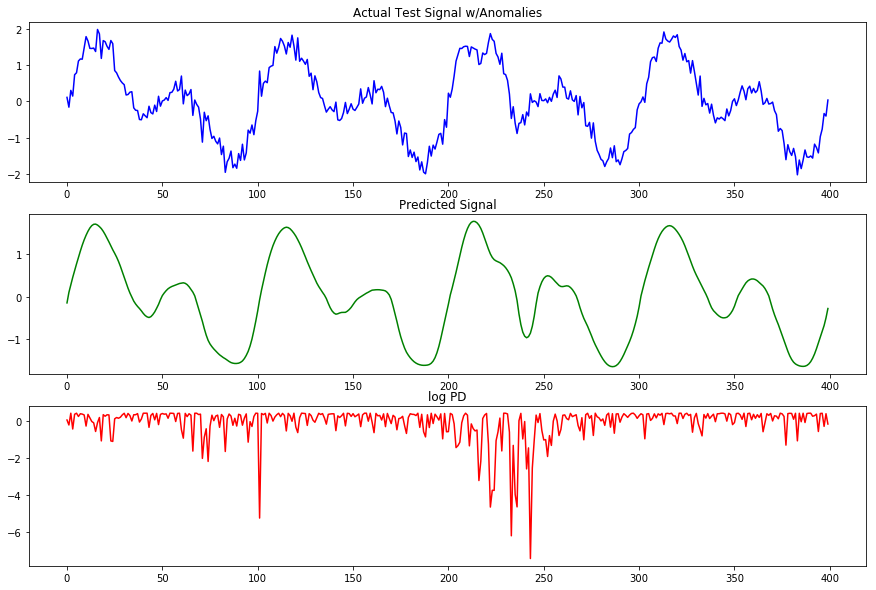

Training duration (s) :  90.82210564613342


In [99]:
run_network()

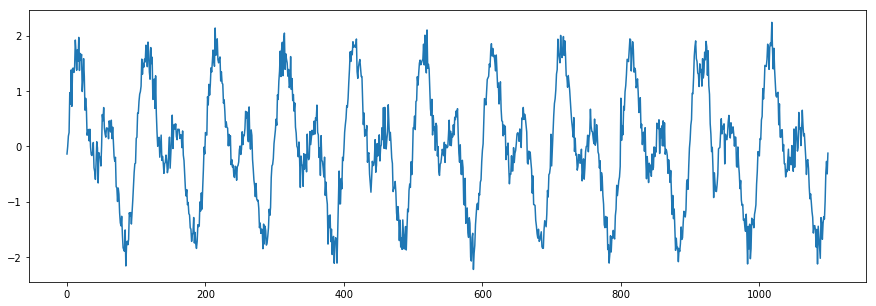

In [115]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

data = gen_wave()
plt.plot(data[900:])